## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
import set_matplotlib_hangul
import nltk
import re 
warnings.filterwarnings('ignore')

from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TreebankWordTokenizer
from konlpy.tag import Okt 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

Hangul OK in your MAC!


In [2]:
# !bash ../input/get_data.sh

In [3]:
train_path = '../data/train.csv'
val_path = '../data/dev.csv'
test_path = '../data/test.csv'

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

print(f"Train shape: {train_df.shape}")
print(f"Val shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")
train_df

Train shape: (12457, 4)
Val shape: (499, 4)
Test shape: (499, 2)


,fname,dialogue,summary,topic
0,train_0,"#Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다...","Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필...",건강검진
1,train_1,"#Person1#: 안녕하세요, Mrs. Parker. 잘 지내셨나요?\n#Pers...","Mrs. Parker가 Ricky와 함께 백신 접종을 위해 방문하였고, Dr. Pe...",백신 접종
2,train_2,"#Person1#: 저기요, 열쇠 세트 본 적 있어요?\n#Person2#: 어떤 ...",#Person1#은 열쇠 세트를 잃어버리고 #Person2#에게 찾는 것을 도와달라...,열쇠 분실
3,train_3,#Person1#: 너 여자친구 있는 거 왜 말 안 했어?\n#Person2#: 미...,#Person1#은 #Person2#가 여자친구가 있고 결혼할 예정이라는 사실을 말...,여자친구와의 결혼
4,train_4,"#Person1#: 안녕, 오늘 너무 멋져 보이네요. 저랑 춤 한 곡 추실래요?\n...","Malik은 Wen과 Nikki에게 춤을 제안하고, Wen은 발을 밟는 것을 감수하...",춤 제안
...,...,...,...,...
12452,train_12455,#Person1#: 안녕하세요. 혹시 맨체스터에서 오신 Mr. Green 맞으신가요...,Tan Ling은 흰머리와 수염이 특징인 Mr. Green을 맞이하여 호텔로 안내합...,호텔 안내
12453,train_12456,"#Person1#: Mister Ewing이 우리 회의장에 4시에 오라고 했지, 맞...",#Person1#과 #Person2#는 Mister Ewing의 요청에 따라 회의장...,회의 준비
12454,train_12457,#Person1#: 오늘 어떻게 도와드릴까요?\n#Person2#: 차를 빌리고 싶...,#Person2#는 #Person1#의 도움으로 5일 동안 소형차를 대여합니다.,차량 대여
12455,train_12458,#Person1#: 너 오늘 좀 기분 안 좋아 보인다? 무슨 일 있어?\n#Pers...,#Person2#의 어머니가 직장을 잃으셨다. #Person2#는 어머니가 우울해하...,실직과 대처


## EDA

In [4]:
test_df

,fname,dialogue
0,test_0,"#Person1#: Ms. Dawson, 받아쓰기 좀 부탁드려야겠어요. \n#Per..."
1,test_1,#Person1#: 드디어 왔네! 뭐가 이렇게 오래 걸렸어?\n#Person2#: ...
2,test_2,"#Person1#: Kate, 여기서 일어난 일을 믿기 힘들 거야.\n#Person..."
3,test_3,"#Person1#: 생일 축하해, 이거 너를 위한 선물이야, Brian.\n#Per..."
4,test_4,#Person1#: 이 올림픽 공원 정말 크다! \n#Person2#: 맞아. 지금...
...,...,...
494,test_495,"#Person1#: 얘, Charlie, 학교 끝나고 우리 집에 와서 나랑 비디오 ..."
495,test_496,#Person1#: 어떻게 시골 음악에 관심을 갖게 되었어요?\n#Person2#:...
496,test_497,"#Person1#: 저기, Alice. 여기는 처음 와봤어요. 어떻게 기계를 사용하..."
497,test_498,#Person1#: Matthew? 안녕! \n#Person2#: Steve! 진짜...


In [5]:
# Data type check
def check_dtype(df, return_data=False):
    object_df = df.select_dtypes(include=['object'])
    num_df = df.select_dtypes(include=['number'])

    print(f"Object Data Type: {object_df.shape[1]}")
    print(f"Number Data Type: {num_df.shape[1]}")

    if return_data: # 데이터 프레임 할당
        return object_df, num_df
    
# Null check
def check_NaN(df):
    nan_value = df.isna().sum()
    nan_ratio = round((nan_value / len(df)) * 100, 2)
    df_nan = pd.DataFrame({'Columns':df.columns, 'Missing_Values':nan_value, 'Missing_ratio%':nan_ratio})
    df_nan = df_nan[df_nan['Missing_Values'] > 0].sort_values(by=['Missing_ratio%'], ascending=False).reset_index(drop=True)
    print(f"Missing Value Columns: {len(df_nan)}")
    return df_nan

# normality check
def check_shapiro(df, sample_size=5000, return_data=False):
    shapiro_data = [] # 정규성 col
    shapiro_Not = [] # 비정규성 col
    shapiro_results = [] # 전체 결과
    df = df.select_dtypes(include=['number']).copy() # 수치형 검정
    
    for col in df.columns:
        values = df[col].dropna()
        values = values.sample(sample_size, random_state=42) # sample_size == 5,000
        stat, p_value = stats.shapiro(values)

        if p_value > 0.05:
            shapiro_data.append(col)
        else:
            shapiro_Not.append(col)
        
        shapiro_results.append({
            "Columns": col,
            "Stat": round(stat, 4),
            "P-value": round(p_value, 4),
            "result": '정규성 만족' if p_value > 0.05 else '불만족'})
            
    print(f"정규성 만족 Columns: {len(shapiro_data)}")            
    print(f"정규성 불만족 Columns: {len(shapiro_Not)}") 

    if return_data:
        return pd.DataFrame(shapiro_results)

# mode check
def check_mode(df):
    df = df.select_dtypes(include=['object']).copy()
    result = []

    for col in df.columns:
        mode_val = df[col].mode()[0] # 최빈값
        mode_ratio = round((df[col] == mode_val).sum() / len(df) * 100, 2)
        unique_cnt = int(df[col].nunique())

        result.append({
            'Columns': col,
            'mode': mode_val,
            'ratio(%)': mode_ratio,
            'Unique_Count': unique_cnt})
    
    result_df = pd.DataFrame(result)
    result_df['Unique_Count'] = result_df['Unique_Count'].astype(int) 
    return result_df

In [6]:
# Count_plot
def count_plot(df, col, figsize=(10, 6), palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel='Count'):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=col, palette=palette)
    plt.title(title if title else f'{col} Count')
    plt.xlabel(xlabel if xlabel is not None else col)
    plt.ylabel(ylabel)
    plt.show()

# bar_plot    
def bar_plot(df, x_col, y_col, figsize=(10, 6), hue=None, palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel=None):
     plt.figure(figsize=figsize)
     
     if hue: # hue 지정
        sns.barplot(x=x_col, y=y_col, hue=hue, data=df, palette=palette)
     else: # hue 지정 X
        sns.barplot(x=x_col, y=y_col, data=df, palette=palette)

     plt.xticks(rotation=rotation)
     plt.title(title)
     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.show()

# box_plot
def box_plot(df1, col, df2=None, x_col=None, ax=None, figsize=(8, 6), color1='skyblue', color2='salmon', title=None, rotation=None, palette=None, order=None):
    if ax is None: # ax가 제공되지 않으면 새로운 figure와 axes를 생성
        fig, ax = plt.subplots(figsize=figsize)

    if x_col is not None: # x_col이 제공되면 범주형 x축으로 박스 플롯
        sns.boxplot(data=df1, x=x_col, y=col, palette=palette if palette else 'viridis', order=order, ax=ax)
        ax.set_xlabel(x_col)
        ax.set_ylabel(col)
        ax.set_title(title if title else f'{col} Distribution by {x_col} (Box Plot)')
        if rotation:
            ax.tick_params(axis='x', rotation=rotation)
        plt.tight_layout() # ax가 제공되었을 때도 레이아웃 조정
    elif df2 is None:
        # 단일 데이터프레임 boxplot (x_col이 없고 df2도 없을 때)
        sns.boxplot(y=df1[col], color=color1, ax=ax)
        ax.set_ylabel(col)
        ax.set_title(title if title else f'{col} (Box Plot)')
    else:
        pass

    if ax is None: # ax가 제공되지 않았을 때만 show 호출
        plt.show()

# hist_plot
def hist_plot(df1, col, df2=None, ax=None, figsize=(8, 6), bins=30, alpha=0.6, color1='skyblue', color2='salmon', label1=None, label2=None, title=None, subplot_title=None):
    if ax is None: # ax가 제공되지 않으면 새로운 figure와 axes를 생성
        fig, ax = plt.subplots(figsize=figsize)
    
    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, label=label1 if label1 else ('Group 1' if df2 is not None else None), ax=ax)
    
    if df2 is not None: # 두 그룹 비교
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, label=label2 if label2 else 'Group 2', ax=ax)
        ax.legend()  # 두 그룹일 때만 범례 표시

    ax.set_title(subplot_title if subplot_title else (title if title else f'{col} Distribution (Histogram + KDE)'))
    ax.set_xlabel(col)
    ax.set_ylabel('Count') 
    
    if ax is None: # ax가 제공되지 않았을 때만 show 호출
        plt.show()

# wordcloud plot
def plot_wordcloud(df, stopwords=None):
    word_freq_dict = dict(zip(df['word'], df['count']))
    font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc' # macOS 폰트 경로

    wordcloud = WordCloud(
        font_path=font_path, # 한글 폰트 경로 지정
        background_color='white', 
        colormap="Accent_r",
        width=2500, 
        height=1500,
        stopwords=stopwords # 불용어 리스트 전달
    ).generate_from_frequencies(word_freq_dict) # dict 형태로 변환된 데이터 전달
    
    plt.figure(figsize=(8,6)) 
    plt.imshow(wordcloud)
    plt.tight_layout(pad=0)
    plt.axis('off')
    plt.show()

In [7]:
# Check Null
check_NaN(train_df)
check_NaN(val_df)
check_NaN(test_df)

Missing Value Columns: 0
Missing Value Columns: 0
Missing Value Columns: 0


,Columns,Missing_Values,Missing_ratio%


### dialogue Length 분석

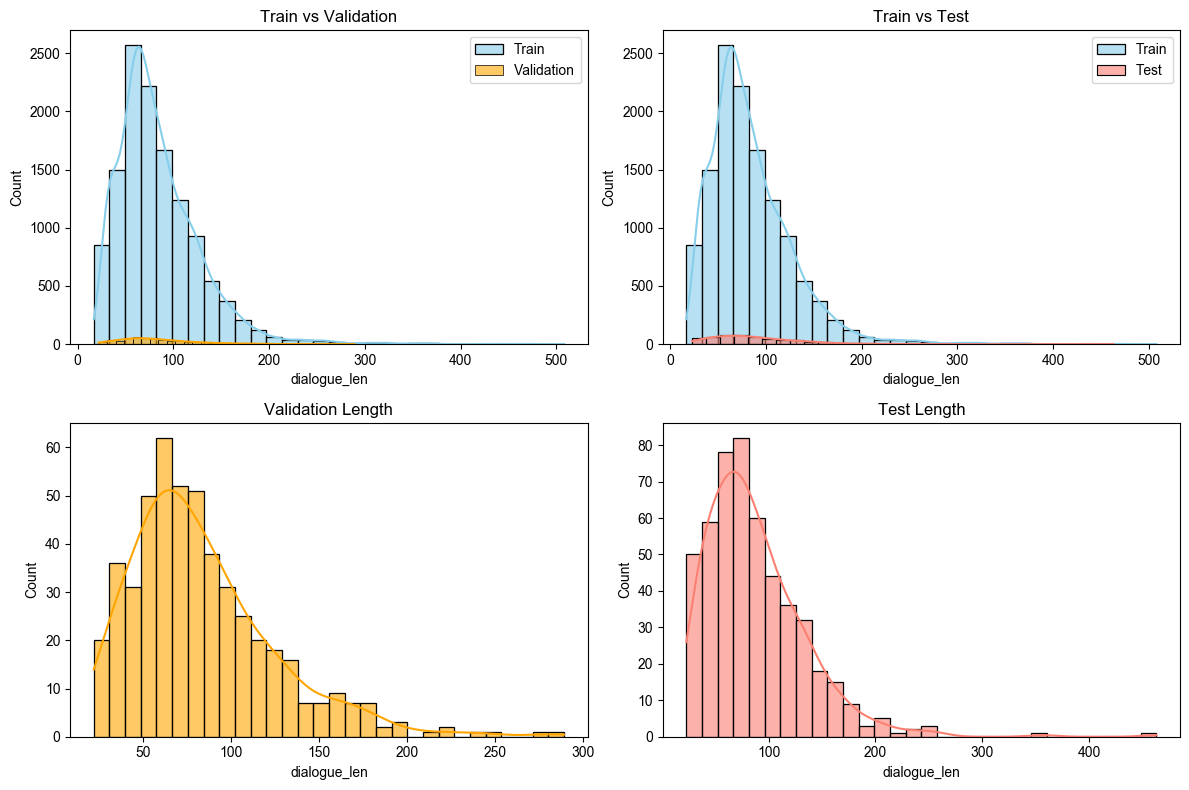

[Train]
count    12457.000000
mean        84.464478
std         43.613074
min         17.000000
25%         56.000000
50%         75.000000
75%        106.000000
max        508.000000
Name: dialogue_len, dtype: float64

[Val]
count    499.000000
mean      83.541082
std       41.547667
min       22.000000
25%       55.000000
50%       75.000000
75%      103.000000
max      289.000000
Name: dialogue_len, dtype: float64

[Test]
count    499.000000
mean      87.971944
std       47.498755
min       23.000000
25%       55.000000
50%       78.000000
75%      111.500000
max      463.000000
Name: dialogue_len, dtype: float64


In [8]:
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: str(x).strip())
val_df['dialogue'] = val_df['dialogue'].apply(lambda x: str(x).strip())
test_df['dialogue'] = test_df['dialogue'].apply(lambda x: str(x).strip())

train_df['dialogue_len'] = train_df['dialogue'].apply(lambda x: len(str(x).split()))
val_df['dialogue_len'] = val_df['dialogue'].apply(lambda x: len(str(x).split()))
test_df['dialogue_len'] = test_df['dialogue'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Train vs Validation 대화 길이
hist_plot(df1=train_df, df2=val_df, col='dialogue_len', ax=axes[0, 0], color2='orange', 
          label1='Train', label2='Validation', subplot_title='Train vs Validation')

# Train vs Test 대화 길이
hist_plot(df1=train_df, df2=test_df, col='dialogue_len', ax=axes[0, 1], 
          label1='Train', label2='Test', subplot_title='Train vs Test')

# Validation 데이터의 대화 길이
hist_plot(df1=val_df, col='dialogue_len', ax=axes[1, 0], color1='orange',
          label1='Validation', subplot_title='Validation Length')

# Test 데이터의 대화 길이
hist_plot(df1=test_df, col='dialogue_len', ax=axes[1, 1], color1='salmon',
          label1='Test', subplot_title='Test Length')

plt.tight_layout()
plt.show()

print(f"[Train]\n{train_df['dialogue_len'].describe()}\n")
print(f"[Val]\n{val_df['dialogue_len'].describe()}\n")
print(f"[Test]\n{test_df['dialogue_len'].describe()}")

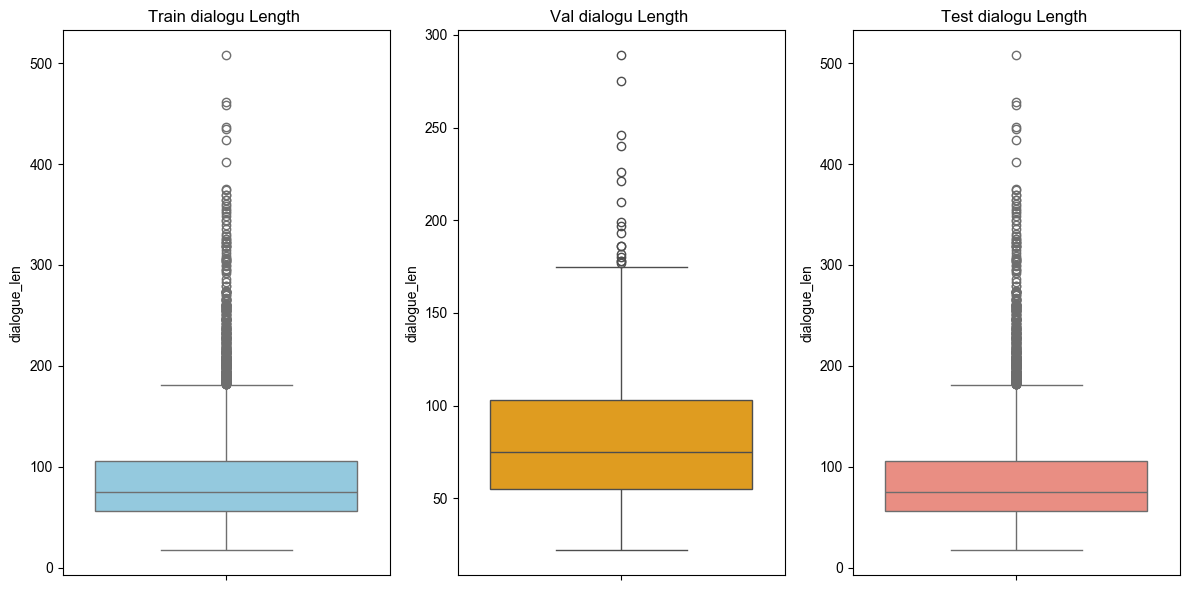

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

box_plot(df1=train_df, col='dialogue_len', ax=axes[0], title='Train dialogu Length ') # Train
box_plot(df1=val_df, col='dialogue_len', ax=axes[1], color1='orange',  title='Val dialogu Length ') # Val
box_plot(df1=train_df, col='dialogue_len', ax=axes[2], color1='salmon', title='Test dialogu Length ') # Test

plt.tight_layout()
plt.show()

### Summary Length 분석

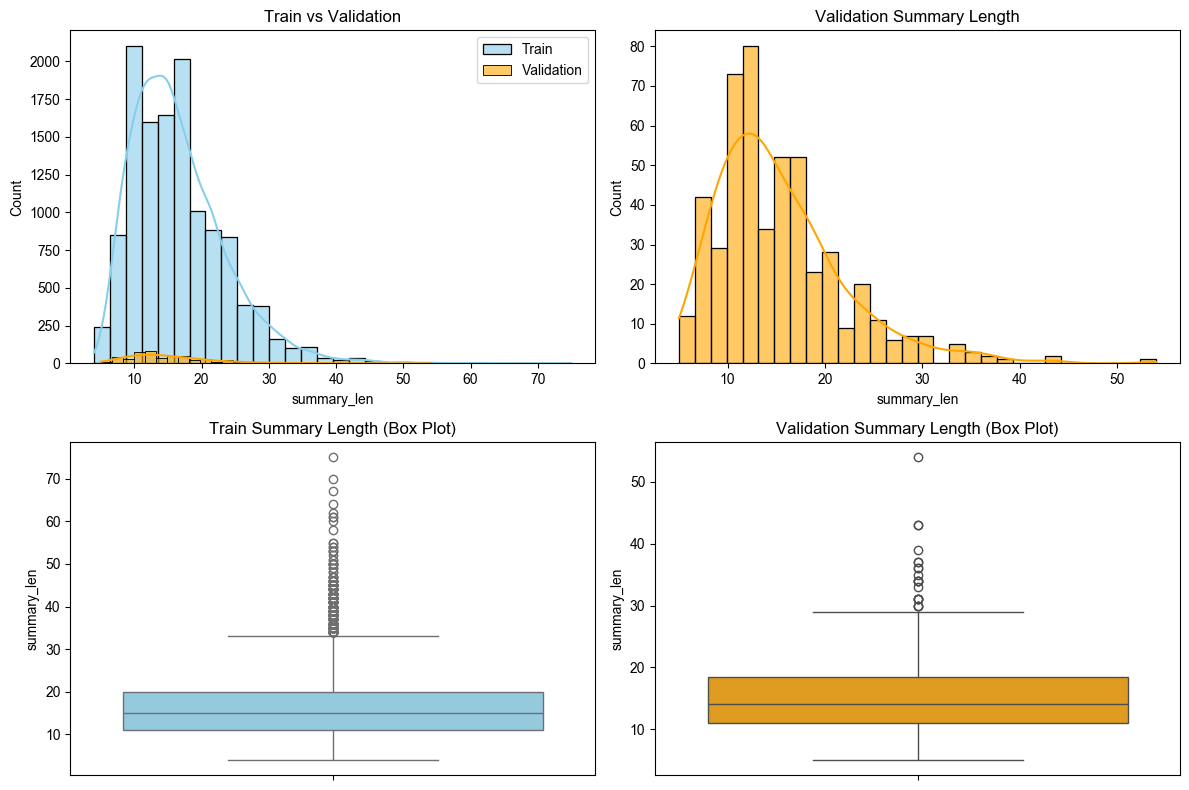

[Train]
count    12457.000000
mean        16.480694
std          7.015613
min          4.000000
25%         11.000000
50%         15.000000
75%         20.000000
max         75.000000
Name: summary_len, dtype: float64

[Val]
count    499.000000
mean      15.348697
std        6.720365
min        5.000000
25%       11.000000
50%       14.000000
75%       18.500000
max       54.000000
Name: summary_len, dtype: float64


In [10]:
train_df['summary_len'] = train_df['summary'].apply(lambda x: len(str(x).split()))
val_df['summary_len'] = val_df['summary'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Train vs Validation 대화 길이
hist_plot(df1=train_df, df2=val_df, col='summary_len', ax=axes[0, 0], color2='orange',
          label1='Train', label2='Validation', subplot_title='Train vs Validation')

# Validation 데이터의 대화 길이
hist_plot(df1=val_df, col='summary_len', ax=axes[0, 1], color1='orange',
          label1='Validation', subplot_title='Validation Summary Length')

box_plot(df1=train_df, col='summary_len', ax=axes[1, 0], title='Train Summary Length (Box Plot)')

box_plot(df1=val_df, col='summary_len', ax=axes[1, 1], color1='orange', 
          title='Validation Summary Length (Box Plot)')

plt.tight_layout()
plt.show()

print(f"[Train]\n{train_df['summary_len'].describe()}\n")
print(f"[Val]\n{val_df['summary_len'].describe()}")

### dialogue_len, summary_len 비율 분석

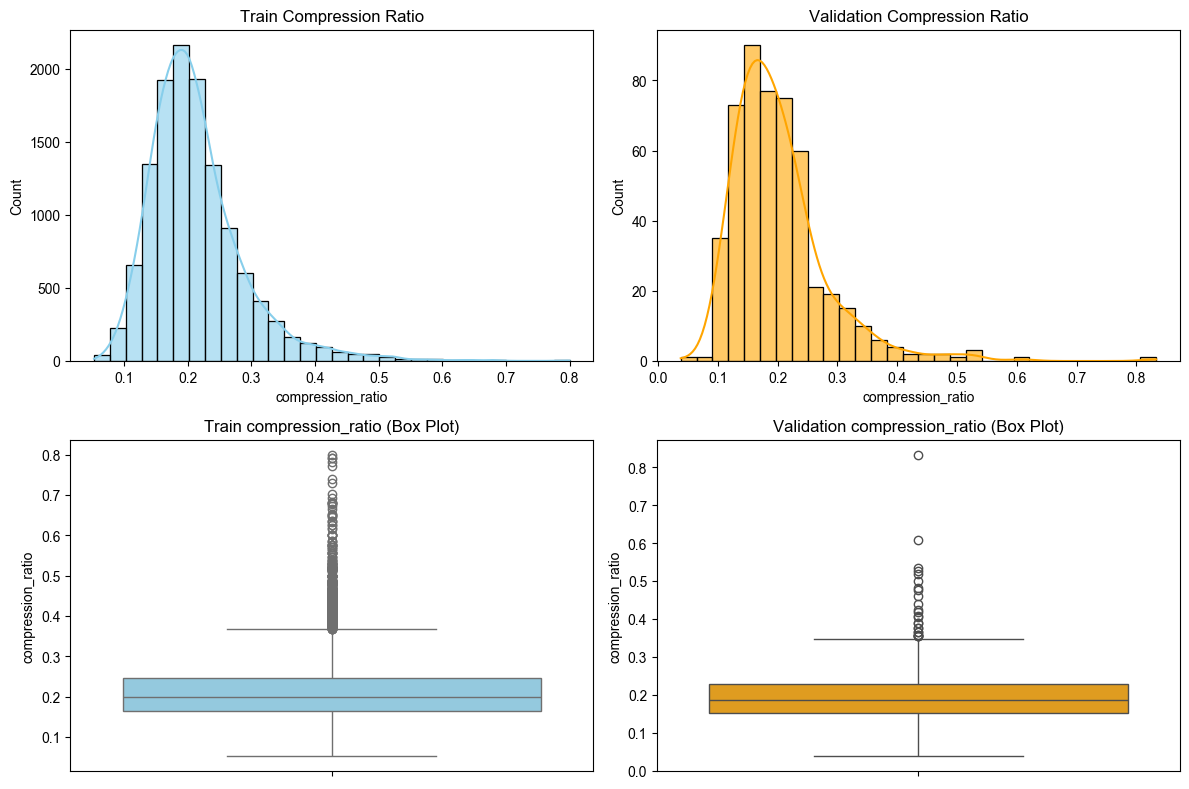

[Train Compression Ratio]
count    12457.000000
mean         0.213563
std          0.076621
min          0.052632
25%          0.163934
50%          0.200000
75%          0.245614
max          0.800000
Name: compression_ratio, dtype: float64

[Val Compression Ratio]
count    499.000000
mean       0.201862
std        0.080844
min        0.037975
25%        0.150943
50%        0.184783
75%        0.229526
max        0.833333
Name: compression_ratio, dtype: float64


In [29]:
# 압축률(Compression Ratio)
train_df['compression_ratio'] = train_df['summary_len'] / train_df['dialogue_len']
val_df['compression_ratio'] = val_df['summary_len'] / val_df['dialogue_len']

# 압축률 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

hist_plot(df1=train_df, col='compression_ratio', ax=axes[0, 0], title='Train Compression Ratio') # Train
hist_plot(df1=val_df, col='compression_ratio', ax=axes[0, 1], color1='orange', title='Validation Compression Ratio') # Val
box_plot(df1=train_df, col='compression_ratio', ax=axes[1, 0], title='Train compression_ratio (Box Plot)') # Train
box_plot(df1=val_df, col='compression_ratio', ax=axes[1, 1], color1='orange', title='Validation compression_ratio (Box Plot)') # Val

plt.tight_layout()
plt.show()

print(f"[Train Compression Ratio]\n{train_df['compression_ratio'].describe()}\n")
print(f"[Val Compression Ratio]\n{val_df['compression_ratio'].describe()}")

### topic 분석

In [12]:
train_df['topic'].nunique()

9235

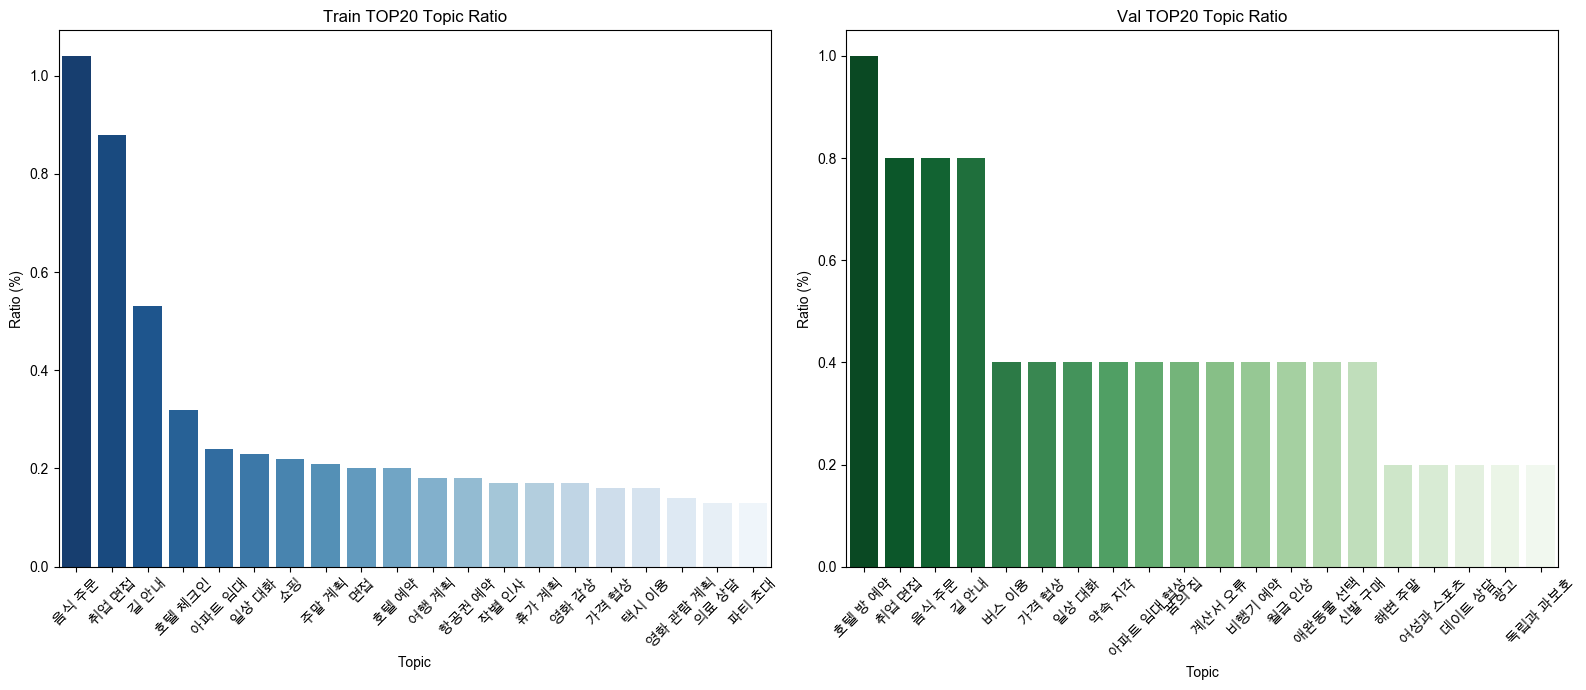

(              topic  Count  topic_ratio
 0             음식 주문    130         1.04
 1             취업 면접    109         0.88
 2              길 안내     66         0.53
 3            호텔 체크인     40         0.32
 4            아파트 임대     30         0.24
 ...             ...    ...          ...
 9230  출퇴근 시간과 교통 문제      1         0.01
 9231     도박에서의 돈 관리      1         0.01
 9232      개인 습관과 취미      1         0.01
 9233       파티에서의 갈등      1         0.01
 9234         실직과 대처      1         0.01
 
 [9235 rows x 3 columns],
            topic  Count  topic_ratio
 0        호텔 방 예약      5          1.0
 1          취업 면접      4          0.8
 2          음식 주문      4          0.8
 3           길 안내      4          0.8
 4          버스 이용      2          0.4
 ..           ...    ...          ...
 470  식당에서 테이블 예약      1          0.2
 471       성희롱 문제      1          0.2
 472        새해 결심      1          0.2
 473    사랑과 결혼 오해      1          0.2
 474     여름방학 일자리      1          0.2
 
 [475 rows x 3 columns

In [13]:
# Train
train_topic_cnt = train_df['topic'].value_counts().reset_index()
train_topic_cnt.columns = ['topic', 'Count']
train_topic_cnt['topic_ratio'] = round((train_topic_cnt['Count'] / len(train_df)) * 100, 2)
train_topic_cnt = train_topic_cnt.sort_values(by=['topic_ratio'], ascending=False).reset_index(drop=True)

# Validation
val_topic_cnt = val_df['topic'].value_counts().reset_index()
val_topic_cnt.columns = ['topic', 'Count']
val_topic_cnt['topic_ratio'] = round((val_topic_cnt['Count'] / len(val_df)) * 100, 2)
val_topic_cnt = val_topic_cnt.sort_values(by=['topic_ratio'], ascending=False).reset_index(drop=True)


# plot
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.barplot(x='topic', y='topic_ratio', data=train_topic_cnt[:20], ax=axes[0], palette='Blues_r')
axes[0].set_title('Train TOP20 Topic Ratio')
axes[0].set_xlabel('Topic')
axes[0].set_ylabel('Ratio (%)')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x='topic', y='topic_ratio', data=val_topic_cnt[:20], ax=axes[1], palette='Greens_r')
axes[1].set_title('Val TOP20 Topic Ratio')
axes[1].set_xlabel('Topic')
axes[1].set_ylabel('Ratio (%)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

train_topic_cnt, val_topic_cnt

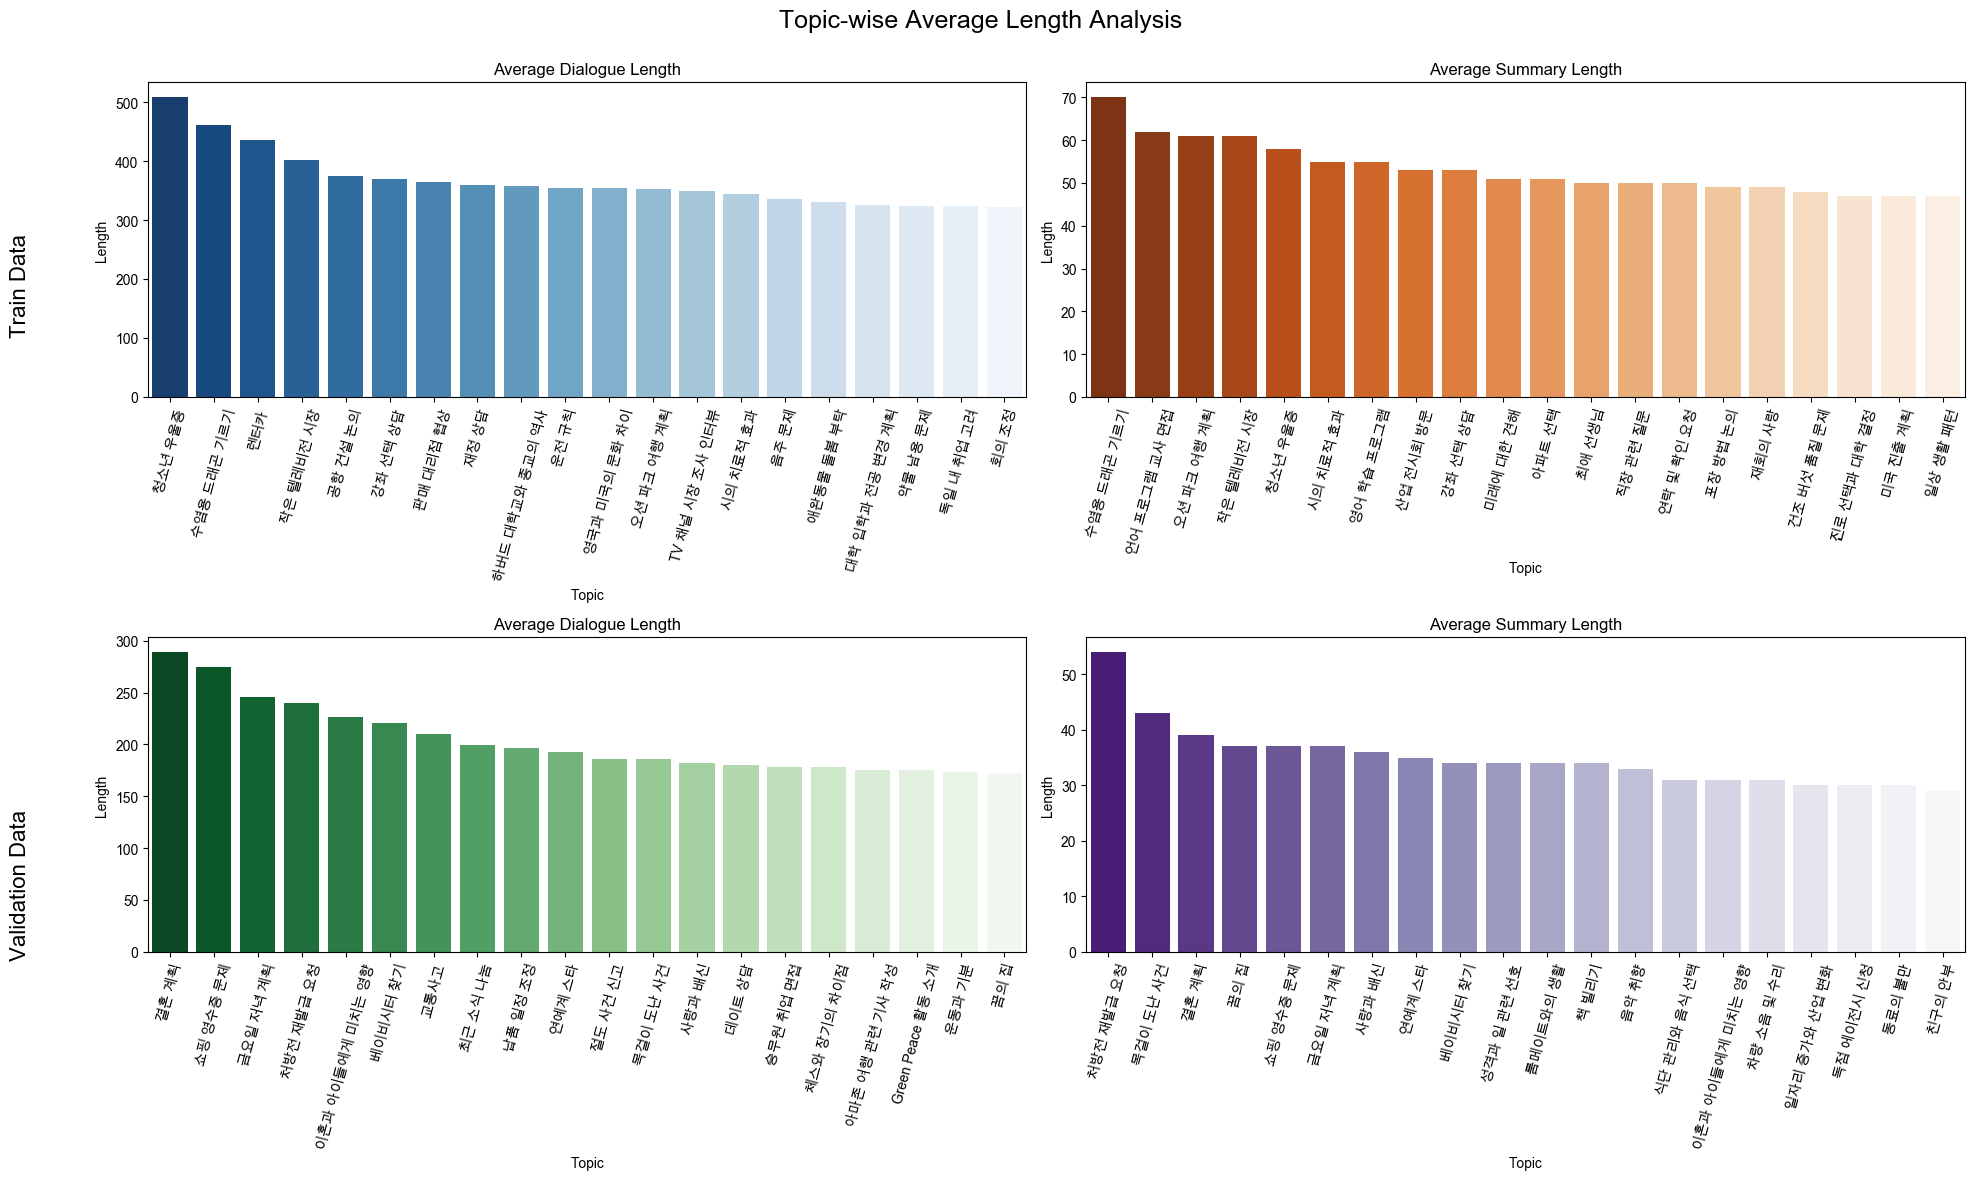

In [14]:
# Train
train_topic_mean_dialogue = train_df.groupby("topic")['dialogue_len'].mean().reset_index()
train_topic_mean_dialogue = train_topic_mean_dialogue.sort_values(by=['dialogue_len'], ascending=False).reset_index(drop=True)
train_top20_topic_dialogue = train_topic_mean_dialogue.head(20)

train_topic_mean_summary = train_df.groupby("topic")['summary_len'].mean().reset_index()
train_topic_mean_summary = train_topic_mean_summary.sort_values(by=['summary_len'], ascending=False).reset_index(drop=True)
train_top20_topic_summary = train_topic_mean_summary.head(20)

# Validation
val_topic_mean_dialogue = val_df.groupby("topic")['dialogue_len'].mean().reset_index()
val_topic_mean_dialogue = val_topic_mean_dialogue.sort_values(by=['dialogue_len'], ascending=False).reset_index(drop=True)
val_top20_topic_dialogue = val_topic_mean_dialogue.head(20)

val_topic_mean_summary = val_df.groupby("topic")['summary_len'].mean().reset_index()
val_topic_mean_summary = val_topic_mean_summary.sort_values(by=['summary_len'], ascending=False).reset_index(drop=True)
val_top20_topic_summary = val_topic_mean_summary.head(20)

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(20, 12)) 
fig.suptitle('Topic-wise Average Length Analysis', fontsize=18) 
fig.text(0.02, 0.75, 'Train Data', ha='center', va='center', rotation=90, fontsize=16)
fig.text(0.02, 0.25, 'Validation Data', ha='center', va='center', rotation=90, fontsize=16)

# Train - dialogue_len 평균
sns.barplot(ax=axes[0, 0], x='topic', y='dialogue_len', data=train_top20_topic_dialogue, palette='Blues_r',)
axes[0, 0].set_title('Average Dialogue Length') 
axes[0, 0].set_xlabel('Topic')
axes[0, 0].set_ylabel('Length')
axes[0, 0].tick_params(axis='x', rotation=75)

# Train - summary_len 평균
sns.barplot(ax=axes[0, 1], x='topic', y='summary_len', data=train_top20_topic_summary, palette='Oranges_r')
axes[0, 1].set_title('Average Summary Length') 
axes[0, 1].set_xlabel('Topic')
axes[0, 1].set_ylabel('Length')
axes[0, 1].tick_params(axis='x', rotation=75)

# Validation - dialogue_len 평균
sns.barplot(ax=axes[1, 0], x='topic', y='dialogue_len', data=val_top20_topic_dialogue, palette='Greens_r')
axes[1, 0].set_title('Average Dialogue Length') 
axes[1, 0].set_xlabel('Topic')
axes[1, 0].set_ylabel('Length')
axes[1, 0].tick_params(axis='x', rotation=75)

# Validation - summary_len 평균
sns.barplot(ax=axes[1, 1], x='topic', y='summary_len', data=val_top20_topic_summary, palette='Purples_r')
axes[1, 1].set_title('Average Summary Length') 
axes[1, 1].set_xlabel('Topic')
axes[1, 1].set_ylabel('Length')
axes[1, 1].tick_params(axis='x', rotation=75)

plt.tight_layout(rect=[0.05, 0, 1, 0.98])
plt.show()


### 단어 빈도 분석

- Train

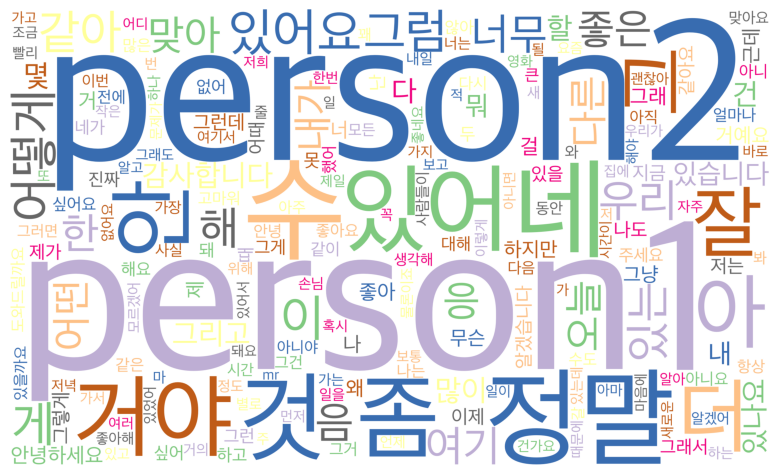

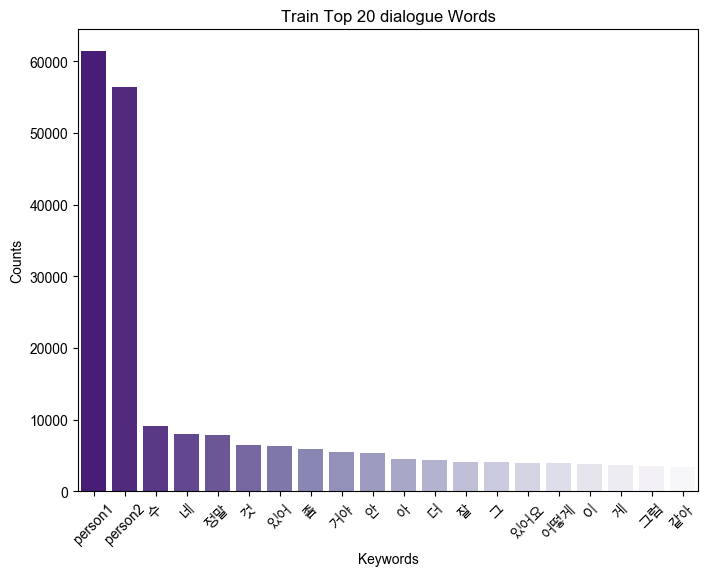

,word,count
0,person1,61361
1,person2,56447
2,수,9122
3,네,8030
4,정말,7808
...,...,...
105131,주겠어,1
105132,아깝네,1
105133,펩시랑,1
105134,테크에서,1


In [15]:
# dialogue 단어 빈도 분석
train_dialogues = train_df['dialogue'].tolist() 
all_text = ' '.join([str(d) for d in train_dialogues if pd.notna(d)])
words = re.findall(r'\b[가-힣a-zA-Z0-9]+\b', all_text.lower()) # 정규 표현식으로 한글, 영문, 숫자 단어 추출
word_counts = Counter(words) # 단어 빈도 계산

word_counts = pd.Series(word_counts).reset_index()
word_counts.columns = ['word', 'count']
word_counts = word_counts.sort_values(by='count', ascending=False).reset_index(drop=True)

plot_wordcloud(word_counts, stopwords=None)
bar_plot(word_counts[:20], x_col='word', y_col='count', figsize=(8, 6), palette="Purples_r", 
         rotation=45, title='Train Top 20 dialogue Words', xlabel='Keywords', ylabel='Counts')
word_counts

- Validation

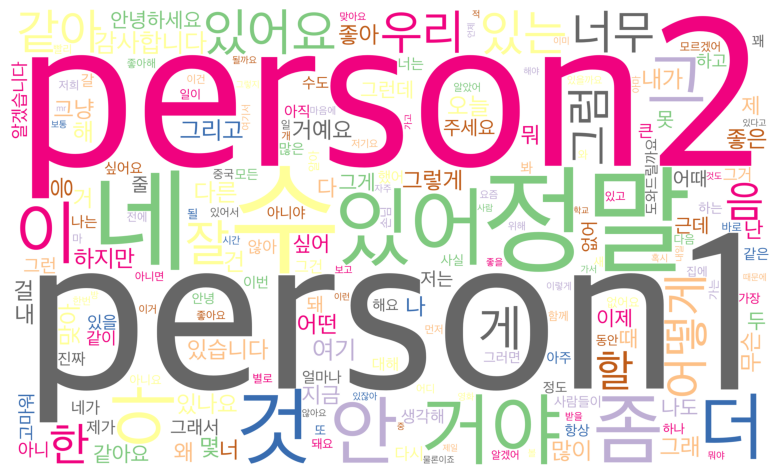

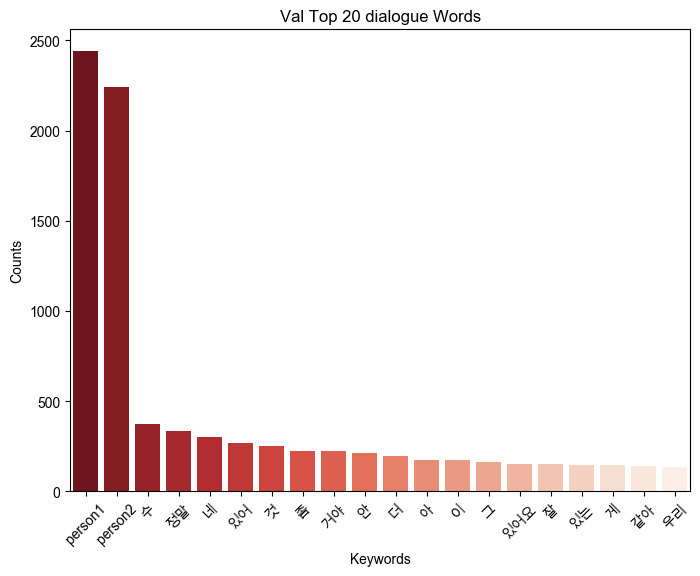

,word,count
0,person1,2439
1,person2,2244
2,수,376
3,정말,333
4,네,300
...,...,...
12694,집세도,1
12695,음식비랑,1
12696,부양하다,1
12697,와이프랑,1


In [16]:
# dialogue 단어 빈도 분석
val_summary = val_df['dialogue'].tolist() 
all_text = ' '.join([str(d) for d in val_summary if pd.notna(d)])
words = re.findall(r'\b[가-힣a-zA-Z0-9]+\b', all_text.lower()) # 정규 표현식으로 한글, 영문, 숫자 단어 추출
word_counts = Counter(words) # 단어 빈도 계산

word_counts = pd.Series(word_counts).reset_index()
word_counts.columns = ['word', 'count']
word_counts = word_counts.sort_values(by='count', ascending=False).reset_index(drop=True)

plot_wordcloud(word_counts, stopwords=None)
bar_plot(word_counts[:20], x_col='word', y_col='count', figsize=(8, 6), palette="Reds_r", 
         rotation=45, title='Val Top 20 dialogue Words', xlabel='Keywords', ylabel='Counts')
word_counts

- Test

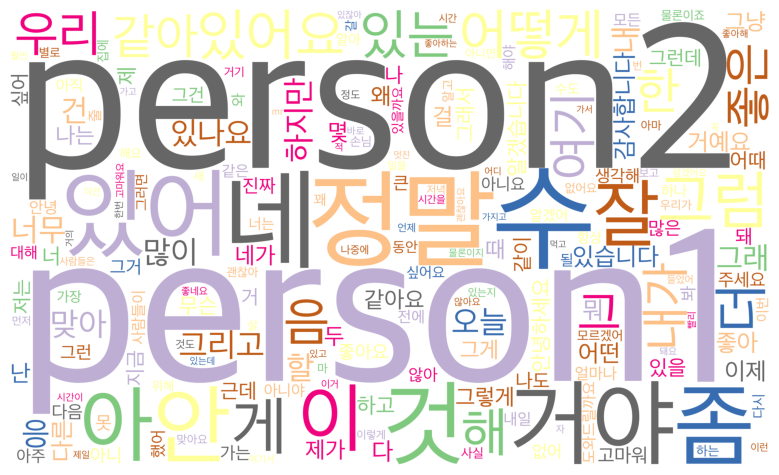

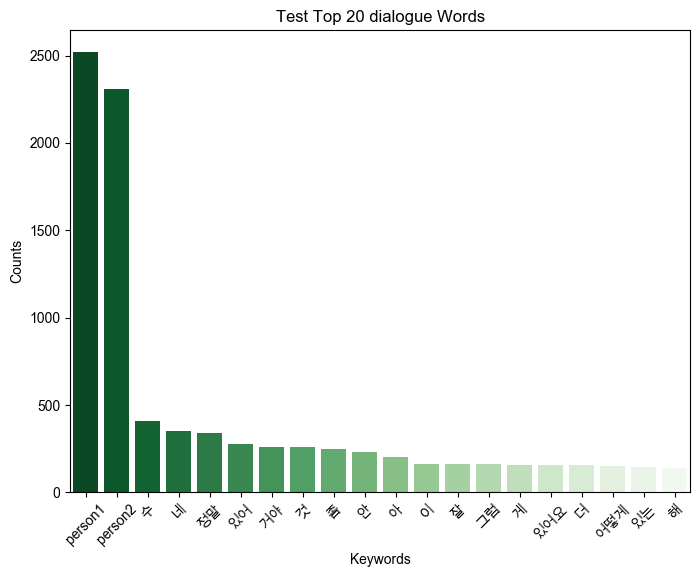

,word,count
0,person1,2518
1,person2,2306
2,수,409
3,네,352
4,정말,338
...,...,...
13187,시안에,1
13188,싶니,1
13189,7월쯤,1
13190,16일쯤,1


In [17]:
# dialogue 단어 빈도 분석
test_summary = test_df['dialogue'].tolist() 
all_text = ' '.join([str(d) for d in test_summary if pd.notna(d)])
words = re.findall(r'\b[가-힣a-zA-Z0-9]+\b', all_text.lower()) # 정규 표현식으로 한글, 영문, 숫자 단어 추출
word_counts = Counter(words) # 단어 빈도 계산

word_counts = pd.Series(word_counts).reset_index()
word_counts.columns = ['word', 'count']
word_counts = word_counts.sort_values(by='count', ascending=False).reset_index(drop=True)

plot_wordcloud(word_counts, stopwords=None)
bar_plot(word_counts[:20], x_col='word', y_col='count', figsize=(8, 6), palette="Greens_r", 
         rotation=45, title='Test Top 20 dialogue Words', xlabel='Keywords', ylabel='Counts')
word_counts

### 대화 - 요약 간 상관관계 분석

In [21]:
check_shapiro(train_df)
train_df[["dialogue_len", "summary_len", "compression_ratio"]].describe()

정규성 만족 Columns: 0
정규성 불만족 Columns: 3


,dialogue_len,summary_len,compression_ratio
count,12457.000000,12457.000000,12457.000000
mean,84.464478,16.480694,0.213563
std,43.613074,7.015613,0.076621
min,17.000000,4.000000,0.052632
25%,56.000000,11.000000,0.163934
50%,75.000000,15.000000,0.200000
75%,106.000000,20.000000,0.245614
max,508.000000,75.000000,0.800000


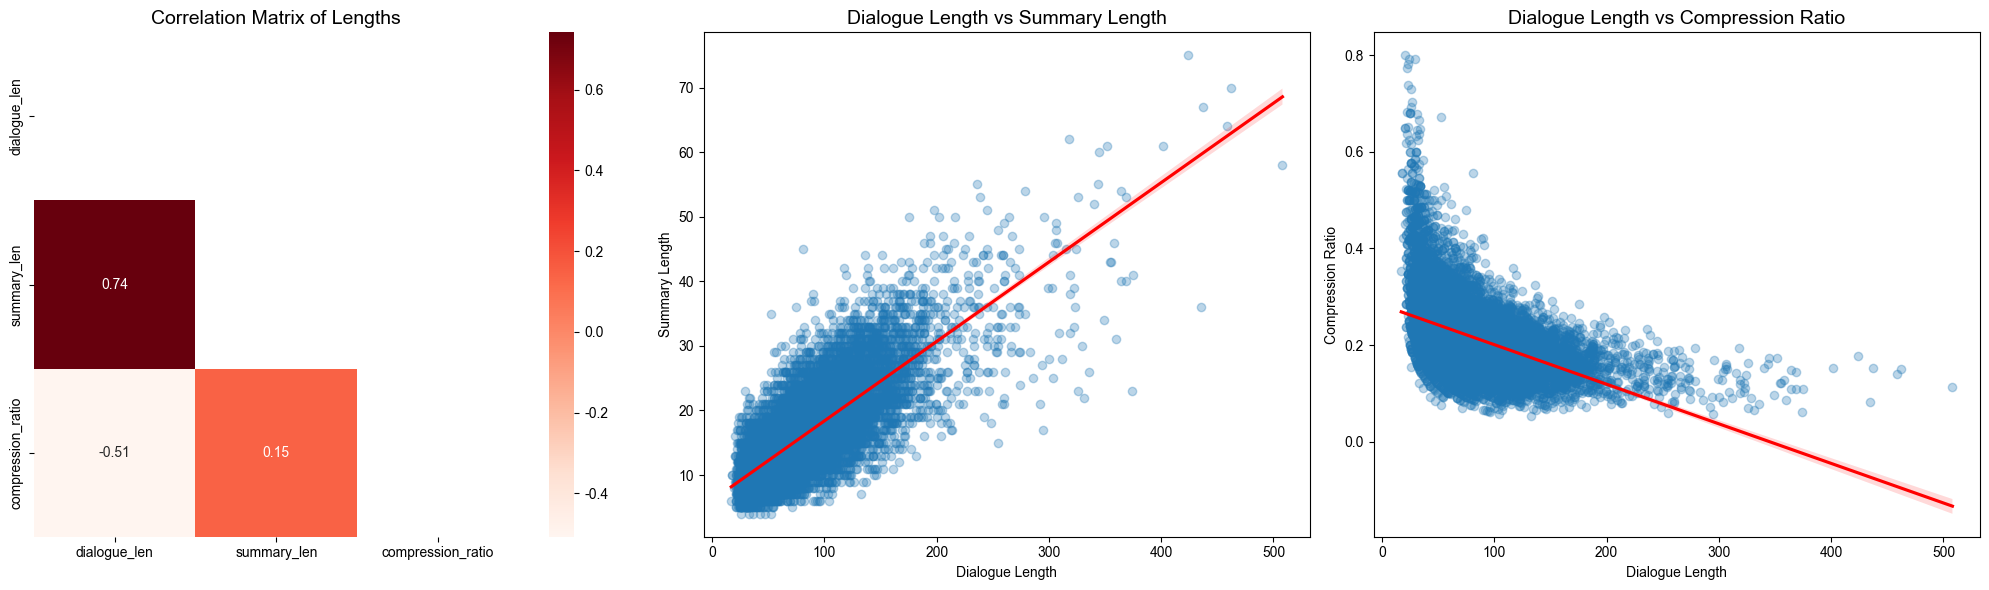

In [28]:
corr_cols = train_df.select_dtypes(include=['number']).columns
corr = train_df[corr_cols].corr(method='spearman') # 비선형 고려
mask = np.triu(np.ones_like(corr, dtype=bool)) # 마스크 생성

fig, axes = plt.subplots(1, 3, figsize=(20, 6)) 

# 상관관계
sns.heatmap(corr, mask=mask, cmap='Reds', annot=True, fmt='.2f', annot_kws={'size': 10}, cbar=True, ax=axes[0])
axes[0].set_title('Correlation Matrix of Lengths', fontsize=14)

# dialogue_len VS summary_len
sns.regplot(data=train_df, x='dialogue_len', y='summary_len', scatter_kws={'alpha':0.3}, line_kws={'color': 'red'}, ax=axes[1]) 
axes[1].set_title('Dialogue Length vs Summary Length', fontsize=14)
axes[1].set_xlabel('Dialogue Length')
axes[1].set_ylabel('Summary Length')

# Dialogue vs compression_ratio
sns.regplot(data=train_df, x='dialogue_len', y='compression_ratio', scatter_kws={'alpha':0.3}, line_kws={'color': 'red'}, ax=axes[2]) 
axes[2].set_title('Dialogue Length vs Compression Ratio', fontsize=14)
axes[2].set_xlabel('Dialogue Length')
axes[2].set_ylabel('Compression Ratio')

plt.tight_layout() 
plt.show()

### 형태소 분석

In [ ]:
okt = Okt()

def preprocess_text(text, stopwords_list):
    tokens = okt.pos(text, norm=True, stem=True) # 형태소 분석
    
    # 명사(Noun), 동사(Verb), 형용사(Adjective)만 추출하고 불용어 제거
    filtered_tokens = [ 
        word for word, pos in tokens 
        if pos in ['Noun', 'Verb', 'Adjective'] and word not in stopwords_list
    ]

    return ' '.join(filtered_tokens)

In [ ]:
# 불용어 리스트 정의
stopwords = ['person1', 'person2']
test_sentence = "안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다"
test_sentences = preprocess_text(test_sentence, stopwords)

test_sentences

'안녕하다 저 이다'

In [ ]:
stopwords = ['person1', 'person2']
train_df['processed_dialogue'] = train_df['dialogue'].apply(lambda x: preprocess_text(x, stopwords))
val_df['processed_dialogue'] = val_df['dialogue'].apply(lambda x: preprocess_text(x, stopwords))
test_df['processed_dialogue'] = test_df['dialogue'].apply(lambda x: preprocess_text(x, stopwords))

train_df[['dialogue', 'processed_dialogue']]

,dialogue,processed_dialogue
0,"#Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다...",안녕하다 저 이다 오늘 무슨 일로 오다 건강검진 받다 오다 네 동안 검진 안 받다 ...
1,"#Person1#: 안녕하세요, Mrs. Parker. 잘 지내셨나요?\n#Pers...",안녕하다 자다 지내다 안녕하다 자다 지내다 있다 저희 둘 백신 맞다 오다 알다 백신...
2,"#Person1#: 저기요, 열쇠 세트 본 적 있어요?\n#Person2#: 어떤 ...",저기 열쇠 세트 보다 적 있다 어떻다 종류 열쇠 열쇠 다섯 개 작다 발 장식 달다 ...
3,#Person1#: 너 여자친구 있는 거 왜 말 안 했어?\n#Person2#: 미...,너 여자친구 있다 거 왜 말 안 하다 미안하다 네 알 있다 줄 알다 사랑 하다 사람...
4,"#Person1#: 안녕, 오늘 너무 멋져 보이네요. 저랑 춤 한 곡 추실래요?\n...",안녕 오늘 멋지다 보이다 저 춤 하다 곡 추다 고맙다 저 춤 자다 못 추다 괜찮다 ...
...,...,...
12452,#Person1#: 안녕하세요. 혹시 맨체스터에서 오신 Mr. Green 맞으신가요...,안녕하다 혹시 맨체스터 오신 맞다 가요 네 알아보다 주다 기쁘다 테 렉스 머리 하얗...
12453,"#Person1#: Mister Ewing이 우리 회의장에 4시에 오라고 했지, 맞...",이 우리 회의장 오라 하다 맞다 응 늦다 말 하다 우리 이스트 요크 지점 몇몇 사람...
12454,#Person1#: 오늘 어떻게 도와드릴까요?\n#Person2#: 차를 빌리고 싶...,오늘 어떻다 도 드릴 끄다 차 빌리다 싶다 어떻다 차갑다 있다 보다 대형차 중형차 ...
12455,#Person1#: 너 오늘 좀 기분 안 좋아 보인다? 무슨 일 있어?\n#Pers...,너 오늘 좀 기분 안 좋다 보이다 무슨 일 있다 엄마 어제 직장 잃다 안타깝다 나다...


### TF-IDF Vectorization

In [ ]:
# TF-IDF Vectorization
tf_idf = TfidfVectorizer(min_df=5, max_df=0.8, ngram_range=(1, 2))
tfidf_matrix = tf_idf.fit_transform(train_df['processed_dialogue'])
print(f"TF-IDF Shape: {tfidf_matrix.shape}")

# 어휘(Vocabulary) 확인
feature_names = tf_idf.get_feature_names_out()
print(f"TF-IDF n-gram Length: {len(feature_names)}")

# IDF 값과 단어 매핑
idf_scores = tf_idf.idf_
word_idf_scores = {feature_names[i]: idf_scores[i] for i in range(len(feature_names))}
sorted_idf_words = sorted(word_idf_scores.items(), key=lambda item: item[1], reverse=True)

print(f"\n전체 데이터셋에서 IDF 점수가 높은 단어들 (상위 10개, 변별력 높은 단어):")
for word, score in sorted_idf_words[:10]:
    print(f"  - '{word}': {score:.4f}")

# IDF 점수가 낮은 순으로 정렬하여 출력 (가장 흔한 단어, 불용어에 가까움)
sorted_idf_words_low = sorted(word_idf_scores.items(), key=lambda item: item[1], reverse=False)

print(f"\n전체 데이터셋에서 IDF 점수가 낮은 단어들 (상위 10개, 흔한 단어):")
for word, score in sorted_idf_words_low[:10]:
    print(f"  - '{word}': {score:.4f}")

TF-IDF Shape: (12457, 26353)
TF-IDF n-gram Length: 26353

전체 데이터셋에서 IDF 점수가 높은 단어들 (상위 10개, 변별력 높은 단어):
  - '가게 그렇다': 8.6384
  - '가게 사다': 8.6384
  - '가게 어떻다': 8.6384
  - '가게 이름': 8.6384
  - '가게 잠깐': 8.6384
  - '가게 하나': 8.6384
  - '가격 다른': 8.6384
  - '가격 따르다': 8.6384
  - '가격 올리다': 8.6384
  - '가격 하나': 8.6384

전체 데이터셋에서 IDF 점수가 낮은 단어들 (상위 10개, 흔한 단어):
  - '그렇다': 1.6469
  - '좋다': 1.6706
  - '어떻다': 1.7231
  - '정말': 1.9028
  - '같다': 1.9044
  - '되다': 2.0022
  - '보다': 2.0225
  - '알다': 2.0580
  - '아니다': 2.0942
  - '없다': 2.1126


- Cosine Similarity

In [ ]:
# Cosine Similarity
cosine_sim_matrix = cosine_similarity(tfidf_matrix)
similarity_threshold = 0.90 

print(f"---유사도 임계값 {similarity_threshold} 이상인 대화 쌍---\n")
found_pairs = set()

for i in range(len(cosine_sim_matrix)):
    for j in range(i + 1, len(cosine_sim_matrix)): # 중복 및 자기 자신 제외
        if cosine_sim_matrix[i][j] >= similarity_threshold:
            # 이미 찾은 쌍인지 확인 (순서 무관)
            pair = tuple(sorted((i, j)))
            if pair not in found_pairs:
                print(f"  - 문서 {i} 와 문서 {j} (유사도: {cosine_sim_matrix[i][j]:.4f})")
                print(f"    문서 {i} 원본: '{train_df['dialogue'][i][:100]}...'")
                print(f"    문서 {j} 원본: '{train_df['dialogue'][j][:100]}...'")
                print("-" * 50)
                found_pairs.add(pair)

if not found_pairs:
    print("임계값 이상의 유사한 대화 쌍이 없음.")

---유사도 임계값 0.9 이상인 대화 쌍---

  - 문서 115 와 문서 9620 (유사도: 0.9154)
    문서 115 원본: '#Person1#: 디저트로 뭐 먹고 싶어?
#Person2#: 뭐가 있어?
#Person1#: 사과 파이, 아이스크림, 초콜릿 케이크, 과일 칵테일이 있어.
#Person2#: ...'
    문서 9620 원본: '#Person1#: 디저트로 뭐 먹고 싶어?
#Person2#: 뭐가 있어?
#Person1#: 사과 파이, 아이스크림, 초콜릿 케이크, 과일 칵테일이 있어.
#Person2#: ...'
--------------------------------------------------
  - 문서 250 와 문서 1642 (유사도: 0.9059)
    문서 250 원본: '#Person1#: 지금 토네이도 경보가 내려졌어. 엄마가 방금 라디오에서 들으셨대.
#Person2#: 토네이도 경보가 뭐야?
#Person1#: 이 지역 어딘가에서 토네이도가 ...'
    문서 1642 원본: '#Person1#: 토네이도 경보가 떴대. 우리 엄마가 방금 라디오에서 들었다고 했어.
#Person2#: 토네이도 경보가 뭐야?
#Person1#: 그게 이 지역 어딘가에 토네이...'
--------------------------------------------------
  - 문서 747 와 문서 10121 (유사도: 0.9083)
    문서 747 원본: '#Person1#: 어제 어디 갔어?
#Person2#: 공원에 테니스 치러 갔어.
#Person1#: 테니스 얼마나 자주 쳐?
#Person2#: 일주일에 두 번. 너는?
#Pe...'
    문서 10121 원본: '#Person1#: 어제 어디 갔었어?
#Person2#: 공원에 테니스 치러 갔어.
#Person1#: 테니스는 얼마나 자주 쳐?
#Person2#: 일주일에 두 번. 너는 어때...'
----------------------------------